## Data Understanding and Pre-Processing

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

c:\Users\mncha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [89]:
df = pd.read_csv('data.csv')
df.head()

,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Company     25160 non-null  object
 1   Date        25160 non-null  object
 2   Close/Last  25160 non-null  object
 3   Volume      25160 non-null  int64 
 4   Open        25160 non-null  object
 5   High        25160 non-null  object
 6   Low         25160 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


dataset info says we should have 5 string types, 1 int type, and 1 datetime type. i think we should have 1 string type (company), 1 int type (volume), 1 datetime, and the rest should be floats (monetary values).

In [91]:
df.columns = df.columns.str.lower()

In [92]:
df = df.rename(columns={'close/last':'close'})

In [93]:
df['company'] = df['company'].astype('string')

df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
                            
money_cols = ['close', 'open', 'high', 'low']
for col in money_cols:
    df[col] = df[col].replace(r'[\$,]', '', regex=True).astype(float)

df.head()

,company,date,close,volume,open,high,low
0,AAPL,2023-07-17,193.99,50520160,191.90,194.3200,191.81
1,AAPL,2023-07-14,190.69,41616240,190.23,191.1799,189.63
2,AAPL,2023-07-13,190.54,41342340,190.50,191.1900,189.78
3,AAPL,2023-07-12,189.77,60750250,189.68,191.7000,188.47
4,AAPL,2023-07-11,188.08,46638120,189.16,189.3000,186.60


making sure everything parsed without error (differences in formatting)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   company  25160 non-null  string        
 1   date     25160 non-null  datetime64[ns]
 2   close    25160 non-null  float64       
 3   volume   25160 non-null  int64         
 4   open     25160 non-null  float64       
 5   high     25160 non-null  float64       
 6   low      25160 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 1.3 MB


In [95]:
df.duplicated().sum()

np.int64(0)

In [96]:
df["company"].value_counts()

company
AAPL    2516
SBUX    2516
MSFT    2516
CSCO    2516
QCOM    2516
META    2516
AMZN    2516
TSLA    2516
AMD     2516
NFLX    2516
Name: count, dtype: Int64

there are 10 companies and an equal amount of market data for each

In [97]:
# sort data in chronological order by company
df = df.sort_values(by=['company', 'date'])
df.head(10)

,company,date,close,volume,open,high,low
2515,AAPL,2013-07-18,15.4199,218632537,15.4779,15.5311,15.3789
2514,AAPL,2013-07-19,15.1768,268548901,15.4679,15.4993,15.1554
2513,AAPL,2013-07-22,15.2254,207648981,15.3379,15.3482,15.1953
2512,AAPL,2013-07-23,14.9639,354477618,15.2143,15.2486,14.9539
2511,AAPL,2013-07-24,15.7325,591624923,15.6761,15.8782,15.5450
2510,AAPL,2013-07-25,15.6607,229432412,15.7393,15.7643,15.5646
2509,AAPL,2013-07-26,15.7496,200082264,15.5464,15.7514,15.5121
2508,AAPL,2013-07-29,15.9925,248025441,15.7429,16.0711,15.7214
2507,AAPL,2013-07-30,16.1900,308960556,16.0700,16.3268,16.0439
2506,AAPL,2013-07-31,16.1618,322499391,16.2496,16.3337,16.0511


## Feature Engineering

In [98]:
# difference between day's close and open prices
df['price_change'] = df['close']-df['open']
# percent change
df['price_change_pct'] = ((df['close'] - df['open']) / df['open']) * 100

# difference between day's highest and lowest prices (volatility)
df['daily_range'] = df['high'] - df['low']

# difference (gap) between current and previous close prices
df['prev_close'] = df.groupby('company')['close'].shift(1)
df['gap'] = df['open'] - df['prev_close']

# day/month/year
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Calculate dailyt returns and volatility
df['daily_return_pct'] = df.groupby('company')['close'].pct_change() * 100
df['volatility_5d'] = df.groupby('company')['daily_return_pct'].rolling(window=5).std().reset_index(level=0, drop=True)

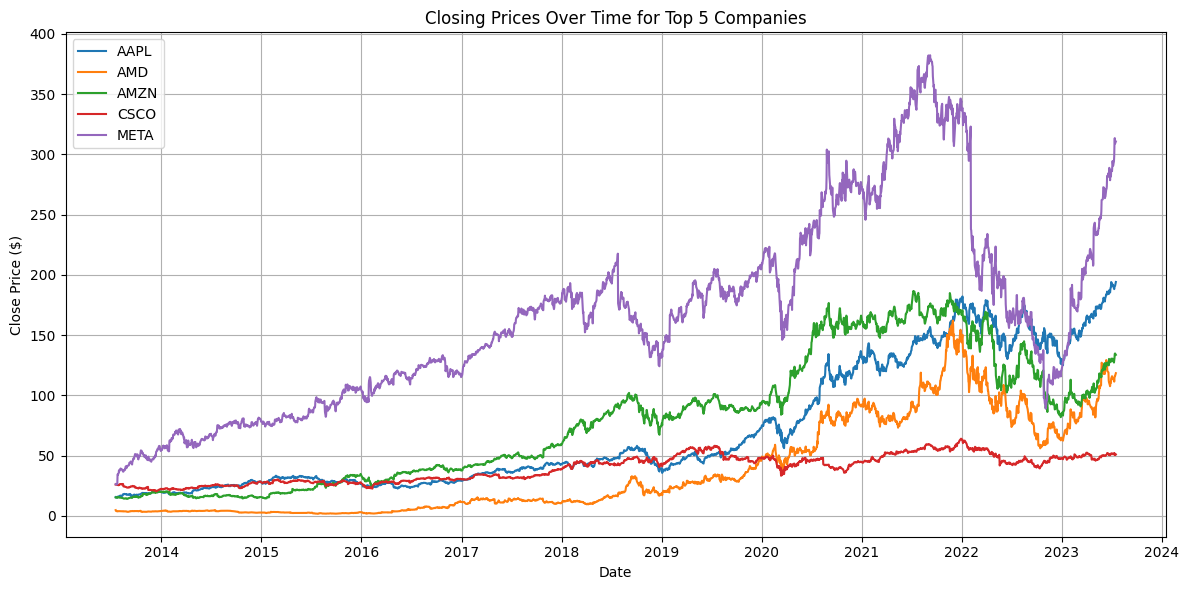

In [99]:
top_companies = df['company'].value_counts().head(5).index.tolist()
df_top = df[df['company'].isin(top_companies)]
plt.figure(figsize=(12, 6))
for company in top_companies:
    company_data = df_top[df_top['company'] == company]
    plt.plot(company_data['date'], company_data['close'], label=company)
plt.title("Closing Prices Over Time for Top 5 Companies")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Predicting AAPL's closing price 250 days into the future
df_aapl = df[df['company'] == 'AAPL'].copy()
# 2. Lag features
lag_features = ['open', 'high', 'low', 'volume', 'gap', 'volatility_5d']
for col in lag_features:
    df_aapl[f'{col}_lag1'] = df_aapl[col].shift(1)
# 3. Create target
df_aapl['target_close'] = df_aapl['close'].shift(-250)
features = [f'{col}_lag1' for col in lag_features]
X = df_aapl[features]
y = df_aapl['target_close']
# 5. Drop rows where target is missing (don't drop X NaNs)
valid = y.notna()
X = X.loc[valid]
y = y.loc[valid]
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 7. Train HistGradientBoostingRegressor (handles NaNs in X)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
# 8. Predict and evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 96.4349201062013
R²: 0.9625270195942718


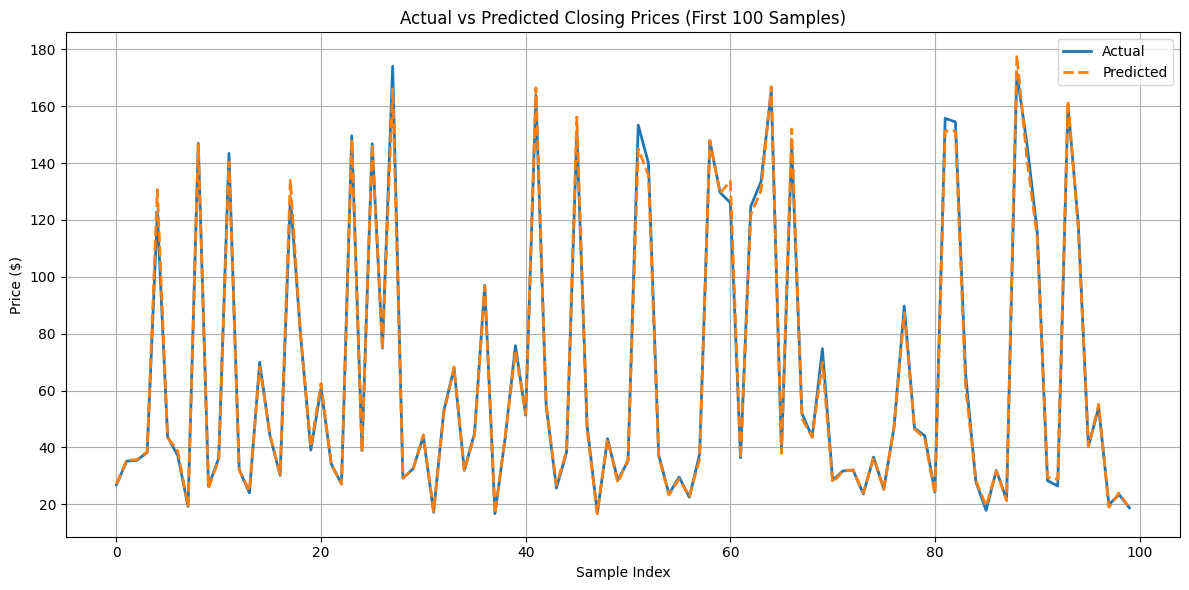

In [101]:
n = 100  # Number of points to show
plt.figure(figsize=(12, 6))
plt.plot(range(n), y_test[:n].values, label="Actual", linewidth=2)
plt.plot(range(n), y_pred[:n], label="Predicted", linewidth=2, linestyle='dashed')
plt.title("Actual vs Predicted Closing Prices (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = df.sort_values(by=['company', 'date'])
lag_features = ['open', 'high', 'low', 'volume', 'gap', 'volatility_5d']
for col in lag_features:
    df[f'{col}_lag1'] = df.groupby('company')[col].shift(1)
# 1-year forward return
df['target_return_1yr'] = df.groupby('company')['close'].shift(-250) / df['close'] - 1
# Final features
features = [f'{col}_lag1' for col in lag_features]
df_model = df.dropna(subset=features + ['target_return_1yr'])
# Add company indicator
X = pd.get_dummies(df_model[features + ['company']], columns=['company'])
y = df_model['target_return_1yr']
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
# Predict and evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


MSE: 0.29816483529639454
R^2: 0.5187152643067127


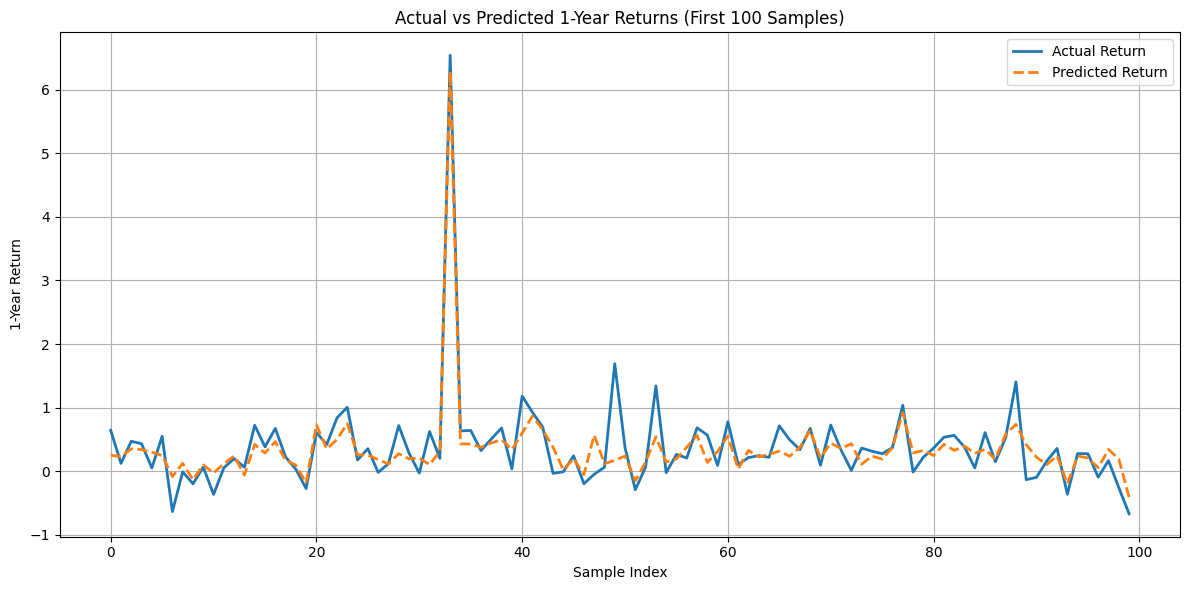

In [107]:
n = 100
plt.figure(figsize=(12, 6))
plt.plot(range(n), y_test[:n].values, label="Actual Return", linewidth=2)
plt.plot(range(n), y_pred[:n], label="Predicted Return", linewidth=2, linestyle='dashed')
plt.title("Actual vs Predicted 1-Year Returns (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("1-Year Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()